In [4]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [5]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\XLewi\AppData\Roaming\nltk_data...


True

In [7]:
df = pd.read_csv("data/processed_data.csv")
print(df['rating_star'].value_counts())

rating_star
2    4438
0    3123
1    1964
Name: count, dtype: int64


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import joblib
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from sklearn.model_selection import StratifiedKFold

df = pd.read_csv("data/processed_data.csv")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment"], df["rating_star"], test_size=0.2, random_state=42, stratify=df["rating_star"]
)

vectorizer = TfidfVectorizer(
    max_features=10000, ngram_range=(1, 3), stop_words="english", min_df=2, max_df=0.9
)

X_train_tfidf = vectorizer.fit_transform(train_texts)
X_val_tfidf = vectorizer.transform(val_texts)

analyzer = SentimentIntensityAnalyzer()

def extract_lexicon_features(text_series):
    sentiment_features = np.array([
        [analyzer.polarity_scores(text)["neg"],  
         analyzer.polarity_scores(text)["neu"],  
         analyzer.polarity_scores(text)["pos"],  
         analyzer.polarity_scores(text)["compound"]] 
        for text in text_series
    ])
    return sentiment_features

X_train_lexicon = extract_lexicon_features(train_texts)
X_val_lexicon = extract_lexicon_features(val_texts)

X_train_combined = hstack([X_train_tfidf, X_train_lexicon])
X_val_combined = hstack([X_val_tfidf, X_val_lexicon])

smote = SMOTE(sampling_strategy="auto", k_neighbors=2, random_state=42)
X_train_resampled, train_labels_resampled = smote.fit_resample(X_train_combined, train_labels)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_param_grid = {
    "C": [0.01,0.05,0.1],
    "kernel": ["linear", "rbf"],  
    "gamma": ["scale", "auto", 0.01, 0.1], 
    "class_weight": ["balanced"],  
}

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=cv_strategy,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X_train_resampled, train_labels_resampled)

joblib.dump(svm_grid.best_estimator_, "best_svm_hybrid.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_hybrid.pkl")

print("Best SVM Parameters:", svm_grid.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best SVM Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss
import numpy as np
import joblib
from scipy.sparse import hstack
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def extract_lexicon_features(text_series):
    """Extracts sentiment lexicon features from text using VADER."""
    features = []
    for text in text_series:
        scores = analyzer.polarity_scores(str(text)) 
        features.append([scores["neg"], scores["neu"], scores["pos"], scores["compound"]])
    return np.array(features)

svm_model = joblib.load("best_svm_hybrid.pkl")
vectorizer = joblib.load("tfidf_vectorizer_hybrid.pkl")

X_train_tfidf = vectorizer.transform(train_texts)
X_val_tfidf = vectorizer.transform(val_texts)

X_train_lexicon = extract_lexicon_features(train_texts)
X_val_lexicon = extract_lexicon_features(val_texts)

X_train_combined = hstack([X_train_tfidf, X_train_lexicon])
X_val_combined = hstack([X_val_tfidf, X_val_lexicon])

train_probs = svm_model.predict_proba(X_train_combined)
val_probs = svm_model.predict_proba(X_val_combined)

train_preds = np.argmax(train_probs, axis=1)
val_preds = np.argmax(val_probs, axis=1)

train_loss = log_loss(train_labels, train_probs)
val_loss = log_loss(val_labels, val_probs)

train_accuracy = accuracy_score(train_labels, train_preds)
val_accuracy = accuracy_score(val_labels, val_preds)

train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
    train_labels, train_preds, average="weighted"
)
val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
    val_labels, val_preds, average="weighted"
)

print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

Training Loss: 0.6607
Validation Loss: 0.7258
Accuracy: 0.6730
Precision: 0.6962
Recall: 0.6730
F1 Score: 0.6821


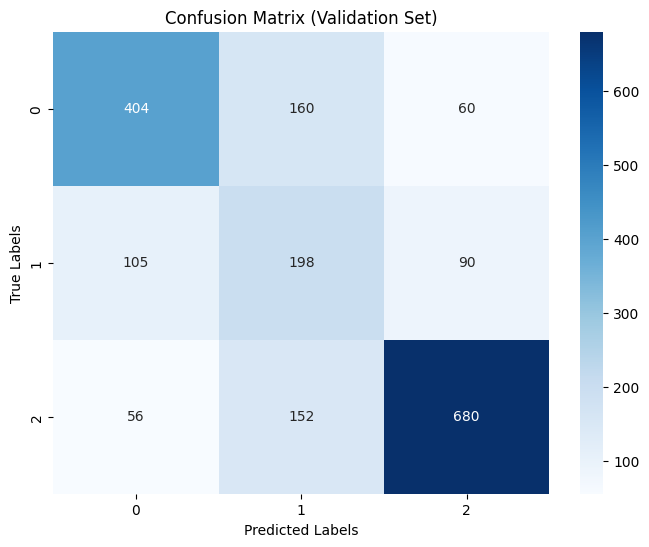

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [20]:
import joblib
import numpy as np
from scipy.sparse import hstack
from nltk.sentiment import SentimentIntensityAnalyzer
from preprocessing import Preprocessing
import nest_asyncio

nest_asyncio.apply()

svm_model = joblib.load("best_svm_hybrid.pkl")
vectorizer = joblib.load("tfidf_vectorizer_hybrid.pkl")

analyzer = SentimentIntensityAnalyzer()

preprocessing_instance = Preprocessing()

def extract_lexicon_features(text):
    """Extracts sentiment lexicon features from text using VADER."""
    scores = analyzer.polarity_scores(text)
    return np.array([[scores["neg"], scores["neu"], scores["pos"], scores["compound"]]])

async def predict_rating(input_text):
    cleaned_text = await preprocessing_instance.preprocessing_pipeline(input_text)

    input_tfidf = vectorizer.transform([cleaned_text])
    input_lexicon = extract_lexicon_features(cleaned_text)
    input_combined = hstack([input_tfidf, input_lexicon])
    final_pred = svm_model.predict(input_combined)

    rating_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return rating_map[final_pred[0]]

user_text = input("Enter a review: ")

predicted_rating = await predict_rating(user_text)

print(f"Predicted Rating: {predicted_rating}")


Predicted Rating: Negative
